# Analysing Xmons with pyEPR

This notebook showcases analysing HFSS eigenmode simulation results using [pyEPR](https://github.com/zlatko-minev/pyEPR). The notebook has to be run on a machine with Ansys Electronics Desktop installed. Consequently, only Windows is supported.


## Instructions

1. (Ansys not required for this step) Run the example simulation script at `klayout_package/python/scripts/simulations/xmons_direct_coupling_pyepr.py`
2. Run `simulation.bat` in the exported `xmons_direct_coupling_pyepr_output` to generate Ansys project files from the GDS files.
3. Put this notebook one folder above the `xmons_direct_coupling_pyepr_output` folder
4. Run this notebook, tune simulation settings, add variable sweeps, run _Analyze_ etc.

In [1]:
import subprocess
from pathlib import Path

import pandas as pd
import pyEPR as epr

In [2]:
pinfo = epr.ProjectInfo(
    project_path = Path.cwd() / 'xmons_direct_coupling_pyepr_output',
    project_name = 'three_coupled_xmons_project',
    design_name  = 'HFSSDesign1',
)

INFO 04:30PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:30PM [load_ansys_project]: 	File path to HFSS project found.
INFO 04:30PM [load_ansys_project]: 	Opened Ansys App
INFO 04:30PM [load_ansys_project]: 	Opened Ansys Desktop v2022.1.0
INFO 04:30PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Simulations/xmons_direct_coupling_pyepr_output/
	Project:   three_coupled_xmons_project
INFO 04:30PM [connect_design]: 	Opened active design
	Design:    HFSSDesign1 [Solution type: Eigenmode]
INFO 04:30PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:30PM [connect]: 	Connected to project "three_coupled_xmons_project" and design "HFSSDesign1" 😀 



In [3]:
# show Ansys objects
pinfo.get_all_object_names()

['Box',
 'Substrate',
 'Signal_1',
 'Signal_2',
 'Signal_3',
 'Signal_4',
 'Signal_5',
 'Signal_6',
 'Signal_7',
 'Signal_8',
 'Signal_9',
 'Ground_10',
 'Port1',
 'Port2',
 'Port3',
 'Port4',
 'Port5',
 'Port6',
 'Port7',
 'Port8',
 'Port9',
 'Junction7',
 'Junction8',
 'Junction9']

In [4]:
# Show Ansys variables
pinfo.get_all_variables_names()

['Lj_7', 'Cj_7', 'Lj_8', 'Cj_8', 'Lj_9', 'Cj_9']

## Setup HFSS eigenmode sim

In [5]:
oDesign = pinfo.design

# create different simulation setup from default
# oDesign.create_em_setup(name='EPR', max_passes=19, n_modes=2, min_freq_ghz=1)

# set Optimetrics, i.e., Ansys parameter sweep setup
oDesign.optimetrics.create_setup(
    name='Parameters1',
    variable='Lj_7',
    swp_params=('12.8nH', '13.6nH', '0.2nH'),
    swp_type='linear_step'
)

Inserting optimetrics setup `Parameters1` for simulation setup: `Setup1`


### Set dissipative elements

Here we set the Ansys objects corresponding to dissipative elements. Solids (_bulk_) and sheets (_surfaces_) are set separately.

In [6]:
junction_numbers = [int(e.split('Junction')[-1]) for e in pinfo.get_all_object_names() if 'Junction' in e]

# Set dissipative elements
pinfo.dissipative['dielectrics_bulk']    = ['Substrate']  # Ansys solids
pinfo.dissipative['dielectric_surfaces'] = [e for e in pinfo.get_all_object_names() if e not in {'Box', 'Substrate'} |
    {item for t in ((f'Port{i}', f'Junction{i}') for i in junction_numbers) for item in t}]  # Ansys sheets
display(pinfo.dissipative['dielectric_surfaces'])

['Signal_1',
 'Signal_2',
 'Signal_3',
 'Signal_4',
 'Signal_5',
 'Signal_6',
 'Signal_7',
 'Signal_8',
 'Signal_9',
 'Ground_10',
 'Port1',
 'Port2',
 'Port3',
 'Port4',
 'Port5',
 'Port6']

### Set junctions

We have to detect the junctions in the simulation setup.
The `junction_numbers` were inferred above and can be used to set the proper format as shown below,
if the normal KQC settings are used. A more complex simulation setup might require doing this manually.

In [7]:
oEditor = oDesign.modeler._modeler
for j in junction_numbers:
    pinfo.junctions[f'j{j}'] = {
        'Lj_variable' : f'Lj_{j}',  # variable specifying junction inductance Lj
        'rect'        : f'Port{j}',  # rectangle on which lumped boundary condition is specified
        'line'        : (name := f'Junction{j}'),  # polyline spanning the length of the rectangle
        'Cj_variable' : f'Cj_{j}',  # variable specifying junction capacitance Cj (optional but needed for dissipation)
        'length'      : f"{oEditor.GetEdgeLength(oEditor.GetEdgeIDsFromObject(name)[0])}{oEditor.GetModelUnits()}",
    }

pinfo.validate_junction_info()

## Run eigenmode Ansys

In [8]:
pinfo.setup.analyze()

INFO 04:30PM [analyze]: Analyzing setup Setup1


### Run Optimetrics

i.e., Ansys parameter sweeps

In [9]:
if pinfo.design.optimetrics.get_setup_names():
    for opti_setup in pinfo.design.optimetrics.get_setup_names():
        pinfo.design.optimetrics.solve_setup(opti_setup)

## Run EPR analysis in Ansys (energies and currents)

In [10]:
# This is the core object for interacting with HFSS and running analysis within HFSS.
eprh = epr.DistributedAnalysis(pinfo)

# eprh.get_ansys_variables()
eprh.get_ansys_frequencies_all()

Design "HFSSDesign1" info:
	# eigenmodes    2
	# variations    6


Freq. (GHz)  Quality Factor
variation mode                             
0         0        3.411559    1.089575e+06
          1        4.934170    1.089626e+06
1         0        3.403715    1.089840e+06
          1        4.952685    1.089333e+06
2         0        3.403708    1.089840e+06
          1        4.933154    1.092208e+06
3         0        3.403700    1.089840e+06
          1        4.895994    1.092225e+06
4         0        3.403692    1.089840e+06
          1        4.859593    1.092227e+06
5         0        3.403683    1.089840e+06
          1        4.823982    1.092228e+06

In [11]:
eprh.set_mode(0, phase=0)

In [12]:
eprh.get_Qsurface_all(0, '0')

Calculating Qsurface for mode 0 (0/1)
p_surf_0 = 0.0023613237622165297


Qsurf_0    423491.270448
dtype: float64

In [13]:
# used with external ports
eprh.calc_Q_external('0', freq_GHz=5)

c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


Series([], dtype: float64)

INFO 06:48PM [hfss_report_full_convergence]: Creating report for variation 0
INFO 06:48PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\three_coupled_xmons_project\HFSSDesign1\hfss_eig_f_convergence.csv


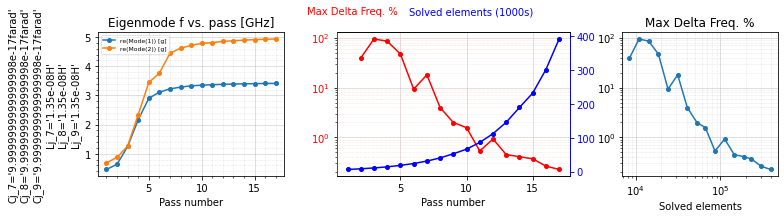

INFO 06:48PM [hfss_report_full_convergence]: Creating report for variation 1
INFO 06:48PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\three_coupled_xmons_project\HFSSDesign1\hfss_eig_f_convergence.csv


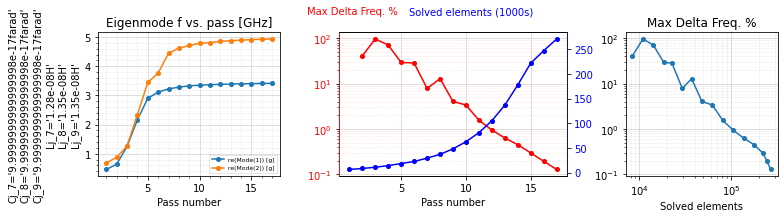

INFO 06:48PM [hfss_report_full_convergence]: Creating report for variation 2
INFO 06:48PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\three_coupled_xmons_project\HFSSDesign1\hfss_eig_f_convergence.csv


In [14]:
eprh.hfss_report_full_convergence()

Computes electromagnetic field energies and Q factors for dissipation (if Cj given in `junctions` above)

In [15]:
eprh.do_EPR_analysis()

c:\users\iqm\pyepr\pyEPR\project_info.py:239: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  options=pd.Series(get_instance_vars(self.options)),



Variation 0  [1/6]


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Ljs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Cjs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 0 at 3.41 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  2.443e-26 1.114e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 98.77%
	j7              0.000311467  (+)        3.86404e-06
		Energy fraction (Lj over Lj&Cj)= 98.77%
	j8              0.994381  (+)        0.0123362
		Energy fraction (Lj over Lj&Cj)= 98.77%
	j9              0.000312618  (+)        3.87831e-06
		(U_tot_cap-U_tot_ind)/mean=0.64%
Calculating Qdielectric_Substrate for mode 0 (0/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_0 = 0.9183562367767784


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 1 at 4.93 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  5.271e-26 3.599e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 97.47%
	j7              0.0420205  (+)        0.00109047
		Energy fraction (Lj over Lj&Cj)= 97.47%
	j8              0.000182701  (+)        4.74126e-06
		Energy fraction (Lj over Lj&Cj)= 97.47%
	j9               0.95125  (+)        0.0246858
		(U_tot_cap-U_tot_ind)/mean=1.26%
Calculating Qdielectric_Substrate for mode 1 (1/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_1 = 0.9189301582525747


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\project_info.py:239: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  options=pd.Series(get_instance_vars(self.options)),



Variation 1  [2/6]


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Ljs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Cjs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 0 at 3.40 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  2.484e-26 1.129e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 98.84%
	j7              0.000284753  (+)        3.33407e-06
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j8              0.994431  (+)        0.0122802
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j9              0.000302521  (+)        3.73581e-06
		(U_tot_cap-U_tot_ind)/mean=0.63%
Calculating Qdielectric_Substrate for mode 0 (0/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_0 = 0.9181299025424536


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 1 at 4.95 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  4.237e-26  2.92e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 97.58%
	j7              0.00788914  (+)        0.000195574
		Energy fraction (Lj over Lj&Cj)= 97.45%
	j8              0.000244387  (+)        6.38974e-06
		Energy fraction (Lj over Lj&Cj)= 97.45%
	j9              0.985225  (+)        0.0257597
		(U_tot_cap-U_tot_ind)/mean=1.27%
Calculating Qdielectric_Substrate for mode 1 (1/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_1 = 0.9191855956256221


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\project_info.py:239: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  options=pd.Series(get_instance_vars(self.options)),



Variation 2  [3/6]


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Ljs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Cjs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 0 at 3.40 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  2.484e-26 1.129e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 98.82%
	j7              0.000297284  (+)        3.53516e-06
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j8              0.994419  (+)         0.01228
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j9              0.000302506  (+)        3.73561e-06
		(U_tot_cap-U_tot_ind)/mean=0.63%
Calculating Qdielectric_Substrate for mode 0 (0/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_0 = 0.9181298838419443


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 1 at 4.93 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%   1.02e-25 6.937e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 97.56%
	j7              0.985983  (+)        0.0246293
		Energy fraction (Lj over Lj&Cj)= 97.47%
	j8              0.000240628  (+)        6.24193e-06
		Energy fraction (Lj over Lj&Cj)= 97.47%
	j9              0.00715708  (+)        0.000185656
		(U_tot_cap-U_tot_ind)/mean=1.22%
Calculating Qdielectric_Substrate for mode 1 (1/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_1 = 0.9167137650799908


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\project_info.py:239: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  options=pd.Series(get_instance_vars(self.options)),



Variation 3  [4/6]


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Ljs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Cjs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 0 at 3.40 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  2.484e-26 1.129e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 98.81%
	j7              0.000310412  (+)        3.74805e-06
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j8              0.994406  (+)        0.0122798
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j9              0.00030249  (+)        3.7354e-06
		(U_tot_cap-U_tot_ind)/mean=0.63%
Calculating Qdielectric_Substrate for mode 0 (0/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_0 = 0.9181298642908986


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 1 at 4.90 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  1.013e-25 6.798e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 97.56%
	j7              0.992318  (+)        0.0247911
		Energy fraction (Lj over Lj&Cj)= 97.51%
	j8              0.000285393  (+)        7.29204e-06
		Energy fraction (Lj over Lj&Cj)= 97.51%
	j9              0.000871822  (+)        2.22758e-05
		(U_tot_cap-U_tot_ind)/mean=1.22%
Calculating Qdielectric_Substrate for mode 1 (1/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_1 = 0.9166997091640486


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\project_info.py:239: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  options=pd.Series(get_instance_vars(self.options)),



Variation 4  [5/6]


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Ljs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Cjs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 0 at 3.40 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  2.484e-26 1.129e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 98.79%
	j7              0.000324174  (+)        3.9735e-06
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j8              0.994392  (+)        0.0122795
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j9              0.000302474  (+)        3.73519e-06
		(U_tot_cap-U_tot_ind)/mean=0.63%
Calculating Qdielectric_Substrate for mode 0 (0/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_0 = 0.9181298437354818


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 1 at 4.86 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  1.013e-25 6.696e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 97.56%
	j7              0.992941  (+)        0.0248095
		Energy fraction (Lj over Lj&Cj)= 97.54%
	j8              0.000305662  (+)        7.69423e-06
		Energy fraction (Lj over Lj&Cj)= 97.54%
	j9              0.000327372  (+)        8.24072e-06
		(U_tot_cap-U_tot_ind)/mean=1.22%
Calculating Qdielectric_Substrate for mode 1 (1/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_1 = 0.9166984712094026


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\project_info.py:239: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  options=pd.Series(get_instance_vars(self.options)),



Variation 5  [6/6]


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Ljs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Cjs = pd.Series({})
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 0 at 3.40 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  2.484e-26 1.129e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 98.77%
	j7              0.000338608  (+)        4.21234e-06
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j8              0.994378  (+)        0.0122793
		Energy fraction (Lj over Lj&Cj)= 98.78%
	j9              0.000302458  (+)        3.73497e-06
		(U_tot_cap-U_tot_ind)/mean=0.63%
Calculating Qdielectric_Substrate for mode 0 (0/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_0 = 0.9181298222355107


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 1 at 4.82 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  1.013e-25 6.598e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 97.56%
	j7              0.993175  (+)        0.0248179
		Energy fraction (Lj over Lj&Cj)= 97.58%
	j8              0.000322833  (+)        8.0078e-06
		Energy fraction (Lj over Lj&Cj)= 97.58%
	j9              0.000173197  (+)        4.29611e-06
		(U_tot_cap-U_tot_ind)/mean=1.22%
Calculating Qdielectric_Substrate for mode 1 (1/1)


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_Substrate_1 = 0.9166979851895489


c:\users\iqm\pyepr\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\three_coupled_xmons_project\HFSSDesign1\2022-08-10 18-48-00.npz




c:\users\iqm\pyepr\pyEPR\project_info.py:239: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  options=pd.Series(get_instance_vars(self.options)),


(WindowsPath('C:/data-pyEPR/three_coupled_xmons_project/HFSSDesign1/2022-08-10 18-48-00.npz'),
 ['0', '1', '2', '3', '4', '5'])

#### Show Q factors
…if dissipation was modelled

In [16]:
for variation in eprh.variations[:2]: # just for the first 2
    Fs, Qs = eprh.get_freqs_bare_pd(variation=variation, frame=False)
    display(pd.DataFrame({'Freq. (GHz)': Fs, 'Quality Factor': Qs}))

,Freq. (GHz),Quality Factor
0,3.411559,1.089575e+06
1,4.934170,1.089626e+06


,Freq. (GHz),Quality Factor
0,3.403715,1.089840e+06
1,4.952685,1.089333e+06


## Post processing
This shouldn't need Ansys anymore.

Check [pyEPR.calcs.back_box_numeric module](https://pyepr-docs.readthedocs.io/en/latest/api/pyEPR.calcs.back_box_numeric.html) for detailed info on Hamiltonian, Kerr etc.

In [17]:
epra = epr.QuantumAnalysis(eprh.data_filename)

# Analyze
epra.analyze_all_variations()

	 Differences in variations:


variation,0,1,2,3,4,5
_Lj_7,1.35e-08H,1.28e-08H,1.3000000000000001e-08H,1.3200000000000001e-08H,1.3399999999999999e-08H,1.3599999999999999e-08H





 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Pm_norm=
modes
0    1.012813
1    1.025581
dtype: float64

Pm_norm idx =
      j7     j8     j9
0  False   True  False
1  False  False   True

*** Different parameters


c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:693: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result['f_ND'] = pd.Series(f1_ND)*1E-6  # MHz
c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:712: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions
c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:717: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctio

_Lj_7    1.35e-08H
Name: 0, dtype: object



*** P (participation matrix, not normlz.)
         j7        j8        j9
0  0.000308  0.982256  0.000309
1  0.040964  0.000178  0.927342

*** S (sign-bit matrix)
   s_j7  s_j8  s_j9
0    -1     1    -1
1    -1     1     1
*** P (participation matrix, normalized.)
   0.00031     0.99  0.00031
     0.041  0.00018     0.95

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       119    0.168
     0.168      228

*** Chi matrix ND (MHz) 

*** Frequencies O1 PT (MHz)
0    3292.558441
1    4706.323477
dtype: float64

*** Frequencies ND (MHz)
Series([], dtype: float64)

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 1

Pm_norm=
modes
0    1.012759
1    1.025797
dtype: float64


c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:693: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result['f_ND'] = pd.Series(f1_ND)*1E-6  # MHz
c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:712: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions



Pm_norm idx =
      j7     j8     j9
0  False   True  False
1  False  False   True

*** Different parameters


c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:717: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions


_Lj_7    1.28e-08H
Name: 1, dtype: object



*** P (participation matrix, not normlz.)
         j7        j8        j9
0  0.000281  0.982360  0.000299
1  0.007690  0.000238  0.960294

*** S (sign-bit matrix)
   s_j7  s_j8  s_j9
0    -1     1    -1
1    -1     1     1
*** P (participation matrix, normalized.)
   0.00028     0.99   0.0003
    0.0077  0.00024     0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       118    0.186
     0.186      246

*** Chi matrix ND (MHz) 

*** Frequencies O1 PT (MHz)
0    3285.239658
1    4706.857546
dtype: float64

*** Frequencies ND (MHz)
Series([], dtype: float64)

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 2

Pm_norm=
modes
0    1.012759
1    1.024718
dtype: float64

Pm_norm idx =
      j7     j8     j9
0  False   True  False
1   True  False  False


c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:693: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result['f_ND'] = pd.Series(f1_ND)*1E-6  # MHz
c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:712: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions



*** Different parameters


c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:717: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions


_Lj_7    1.3000000000000001e-08H
Name: 2, dtype: object



*** P (participation matrix, not normlz.)
         j7        j8        j9
0  0.000294  0.982348  0.000299
1  0.962103  0.000235  0.006984

*** S (sign-bit matrix)
   s_j7  s_j8  s_j9
0    -1     1    -1
1    -1    -1     1
*** P (participation matrix, normalized.)
   0.00029     0.99   0.0003
      0.99  0.00023    0.007

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       118    0.178
     0.178      235

*** Chi matrix ND (MHz) 

*** Frequencies O1 PT (MHz)
0    3285.239119
1    4697.905621
dtype: float64

*** Frequencies ND (MHz)
Series([], dtype: float64)

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 3



c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:693: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result['f_ND'] = pd.Series(f1_ND)*1E-6  # MHz


Pm_norm=
modes
0    1.012759
1    1.024715
dtype: float64

Pm_norm idx =
      j7     j8     j9
0  False   True  False
1   True  False  False

*** Different parameters


c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:712: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions
c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:717: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions


_Lj_7    1.3200000000000001e-08H
Name: 3, dtype: object



*** P (participation matrix, not normlz.)
         j7        j8        j9
0  0.000307  0.982335  0.000299
1  0.968285  0.000278  0.000851

*** S (sign-bit matrix)
   s_j7  s_j8  s_j9
0    -1     1    -1
1    -1    -1     1
*** P (participation matrix, normalized.)
   0.00031     0.99   0.0003
      0.99  0.00028  0.00085

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       118    0.198
     0.198      238

*** Chi matrix ND (MHz) 

*** Frequencies O1 PT (MHz)
0    3285.225151
1    4657.683339
dtype: float64

*** Frequencies ND (MHz)
Series([], dtype: float64)

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 4

Pm_norm=
modes
0    1.012759
1    1.024718
dtype: float64


c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:693: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result['f_ND'] = pd.Series(f1_ND)*1E-6  # MHz



Pm_norm idx =
      j7     j8     j9
0  False   True  False
1   True  False  False


c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:712: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions
c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:717: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



*** Different parameters


_Lj_7    1.3399999999999999e-08H
Name: 4, dtype: object



*** P (participation matrix, not normlz.)
         j7        j8        j9
0  0.000320  0.982322  0.000299
1  0.968888  0.000298  0.000319

*** S (sign-bit matrix)
   s_j7  s_j8  s_j9
0    -1     1    -1
1    -1    -1     1
*** P (participation matrix, normalized.)
   0.00032     0.99   0.0003
      0.99   0.0003  0.00032

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       118    0.209
     0.209      239

*** Chi matrix ND (MHz) 

*** Frequencies O1 PT (MHz)
0    3285.215144
1    4620.951612
dtype: float64

*** Frequencies ND (MHz)
Series([], dtype: float64)

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 5



c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:693: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result['f_ND'] = pd.Series(f1_ND)*1E-6  # MHz
c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:712: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions


Pm_norm=
modes
0    1.012759
1    1.024720
dtype: float64

Pm_norm idx =
      j7     j8     j9
0  False   True  False
1   True  False  False


c:\users\iqm\pyepr\pyEPR\core_quantum_analysis.py:717: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



*** Different parameters


_Lj_7    1.3599999999999999e-08H
Name: 5, dtype: object



*** P (participation matrix, not normlz.)
         j7        j8        j9
0  0.000334  0.982308  0.000299
1  0.969112  0.000315  0.000169

*** S (sign-bit matrix)
   s_j7  s_j8  s_j9
0    -1     1    -1
1    -1    -1     1
*** P (participation matrix, normalized.)
   0.00033     0.99   0.0003
      0.99  0.00032  0.00017

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       118     0.22
      0.22      239

*** Chi matrix ND (MHz) 

*** Frequencies O1 PT (MHz)
0    3285.205505
1    4585.199133
dtype: float64

*** Frequencies ND (MHz)
Series([], dtype: float64)

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


OrderedDict([('0',
              OrderedDict([('f_0', 0    3411.559031
                            1    4934.169785
                            Name: 0, dtype: float64),
                           ('f_1',
                            0    3292.558441
                            1    4706.323477
                            dtype: float64),
                           ('f_ND', Series([], dtype: float64)),
                           ('chi_O1',
                                       0           1
                            0  118.91657    0.168040
                            1    0.16804  227.762288),
                           ('chi_ND',
                            Empty DataFrame
                            Columns: []
                            Index: []),
                           ('ZPF',
                            array([[-0.00658359,  0.37436707, -0.00659574],
                                   [-0.09135961,  0.00602414,  0.44020632]])),
                           ('Pm_normed',
   

In [18]:
epra.print_info()

	 Differences in variations:


variation,0,1,2,3,4,5
_Lj_7,1.35e-08H,1.28e-08H,1.3000000000000001e-08H,1.3200000000000001e-08H,1.3399999999999999e-08H,1.3599999999999999e-08H


In [19]:
epra.report_results()

#### Mode frequencies (MHz)

###### Numerical diagonalization

variation,0,1,2,3,4,5


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,
variation,


This already has anharmonicity and Kerr

(<Figure size 720x432 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Modal frequencies (MHz)'}, xlabel='Lj_8'>,
         <AxesSubplot:title={'center':'Anharmonicities (MHz)'}, xlabel='Lj_8'>],
        [<AxesSubplot:title={'center':'Quality factors'}, xlabel='Lj_8'>,
         <AxesSubplot:title={'center':'Cross-Kerr frequencies (MHz)'}, xlabel='Lj_8'>]],
       dtype=object))

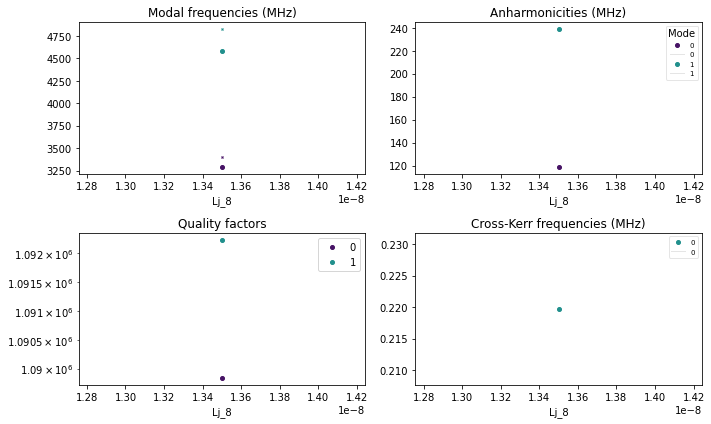

In [20]:
epra.plot_hamiltonian_results(swp_variable='Lj_8')

## Example: Manipulating fields directly

Easiest way to get computed fields

In [21]:
eprh.set_mode(0) # selects qubit

# Calculate the EPR p_dielectic
p_dielectric, (ℰ_substr, ℰ_total) = eprh.calc_p_electric_volume('Substrate', 'AllObjects')
print(f'Energy in silicon substrate  = {100*p_dielectric:.1f}%')

p_vac, (ℰ_vac, ℰ_total) = eprh.calc_p_electric_volume('Box', E_total=ℰ_total)  # Vacuum
print(f'Energy in vacuum = {100*p_vac:.1f}%')

Energy in silicon substrate  = 91.8%
Energy in vacuum = 8.2%


There's also an interface for the _Fields Calculator_ in Ansys which can be used for arbitrary computations

In [22]:
volume = 'AllObjects'

calcobject = epr.ansys.CalcObject([], eprh.setup)
vecE = calcobject.getQty("E").smooth()
A = vecE.times_eps()
B = vecE.conj()
A = A.dot(B)
A = A.real()
A = A.integrate_vol(name=volume)

E_total = A.evaluate(lv=eprh._get_lv())  # lv stands for variation
# This command numerically evaluates and displays the
# results of calculator operation
E_total

4.85213797214913e-26

## Quit Ansys

In [23]:
# Save HFSS project file
pinfo.project.save()
# This allows Ansys to be closed, but doesn't close it
pinfo.disconnect()

In [24]:
# This closes Ansys as well
subprocess.call("taskkill /f /im ansysedt.exe", shell=True)

0